<a href="https://colab.research.google.com/github/mechanic3000/GB_PyTorch_course/blob/Lesson_04/Lesson_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 4. CNN Свертки
  Обучите CNN (самописная) на CIFAR-100.

  Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

  *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.


In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [46]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

Files already downloaded and verified


torch.Size([128, 3, 32, 32])
tensor(11)


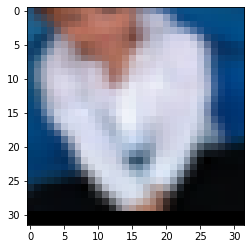

In [30]:
for img, lbl in train_loader:
  print(img.shape)
  print(lbl[0])
  plt.imshow(img[0].permute(1,2,0))
  break

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [32]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [34]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                  [-1, 100]           6,100
Total params: 196,806
Trainable params: 196,806
Non-trainable params: 0
-------------------------------

In [35]:
num_epochs = 10

for epoch in range(num_epochs):  
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = net(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

Epoch 0 valid_loss 79.23333740234375
Epoch 1 valid_loss 78.04564666748047
Epoch 2 valid_loss 81.78667449951172
Epoch 3 valid_loss 74.61417388916016
Epoch 4 valid_loss 74.60105895996094
Epoch 5 valid_loss 72.28382110595703
Epoch 6 valid_loss 68.74481964111328
Epoch 7 valid_loss 69.60255432128906
Epoch 8 valid_loss 77.77237701416016
Epoch 9 valid_loss 70.19519805908203
Training is finished!


### ImageNet Resnet-50

In [47]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
for param in list(resnet50.parameters())[:]:
  param.requires_grad = False

In [49]:
resnet50.fc = nn.Linear(2048, 100)

In [50]:
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [51]:
resnet50 = resnet50.to(device)

In [52]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [53]:
params_to_update

[Parameter containing:
 tensor([[ 1.0272e-02,  5.6018e-05,  6.2499e-03,  ..., -1.3558e-02,
          -1.3317e-02,  7.9372e-03],
         [-8.8711e-04,  1.3159e-03, -1.2087e-02,  ..., -1.3500e-03,
           3.4744e-03,  2.3402e-03],
         [ 9.3268e-03,  1.5787e-02, -1.1798e-02,  ...,  9.5738e-03,
           1.3147e-02, -1.6269e-03],
         ...,
         [ 9.7009e-04, -1.5805e-02,  7.3765e-03,  ..., -1.6814e-02,
          -8.1301e-03, -9.4185e-04],
         [-1.0362e-02,  1.5177e-02, -1.7904e-02,  ...,  8.0575e-03,
          -1.1224e-02,  1.4106e-02],
         [ 8.9248e-03,  1.5482e-02, -1.8212e-02,  ...,  1.7819e-02,
           1.7437e-02,  2.1167e-02]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-9.2554e-03,  1.7022e-02,  8.4291e-03, -1.4575e-02, -1.9235e-02,
          1.7148e-02,  1.6710e-02,  1.1158e-02, -2.2039e-02,  1.5829e-02,
         -1.6304e-02,  1.4651e-02, -5.2885e-03, -1.1013e-02,  2.6113e-04,
         -1.7770e-02, -1.5087e-02,  1.3776e-02,  

In [55]:

num_epochs = 10

for epoch in range(num_epochs):  
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = resnet50(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

Epoch 0 valid_loss 74.32579040527344
Epoch 1 valid_loss 73.46196746826172
Epoch 2 valid_loss 72.03599548339844
Epoch 3 valid_loss 72.33522033691406
Epoch 4 valid_loss 71.48048400878906
Epoch 5 valid_loss 72.27799224853516
Epoch 6 valid_loss 71.0646743774414
Epoch 7 valid_loss 70.5198745727539
Epoch 8 valid_loss 70.52606964111328
Epoch 9 valid_loss 71.2808609008789
Training is finished!


### ImageNet Resnet-50 с аугментацией данных.

In [44]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [58]:
resnet50 = models.resnet50(pretrained=True)

for param in list(resnet50.parameters())[:]:
  param.requires_grad = False

resnet50.fc = nn.Linear(2048, 100)
resnet50 = resnet50.to(device)

params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [60]:

num_epochs = 10

for epoch in range(num_epochs):  
    resnet50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = resnet50(X.to(device))
        loss = criterion(output, y.to(device))
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

Epoch 0 valid_loss 73.86024475097656
Epoch 1 valid_loss 72.60516357421875
Epoch 2 valid_loss 71.51356506347656
Epoch 3 valid_loss 72.29499053955078
Epoch 4 valid_loss 72.88732147216797
Epoch 5 valid_loss 70.7462387084961
Epoch 6 valid_loss 69.50745391845703
Epoch 7 valid_loss 70.12284088134766
Epoch 8 valid_loss 71.24120330810547
Epoch 9 valid_loss 69.21424102783203
Training is finished!
